# MNIST Dataset Preparation

We first need to download the MNIST dataset. Since the classical link from Yann LeCun is no longer available, we will use the gzipped files from the Google Cloud Storage bucket.

- [Google MNIST Train Images](https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz)
- [Google MNIST Train Labels](https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz)
- [Google MNIST Test Images](https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz)
- [Google MNIST Test Labels](https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz)

Since each image consists of 784 pixels, we will scale it down first with the Lanczos filter to 14x14 pixels. The Lanczos filter is chosen because it preserves fine details such as thin strokes and holes (e.g., in the digit 8) without making already thick digits appear even fatter.

After downscaling, the images are binarized with a global threshold of 0.5. The labels are binarized in a way such that the digits 0-4 are labelled as 0 and the digits 5-9 are labelled as 1.

Since the training takes long in some instances, the training set is limited to 10,000 samples and the test set to 1,500 samples. Since we are dealing only with 196 features, everything can be stored in a single CSV file with 197 columns.

In [1]:
import os
import requests
import gzip

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# download the raw MNIST dataset if not already present

data_dir = "../data/mnist"

base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

files = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images": "t10k-images-idx3-ubyte.gz",
    "test_labels": "t10k-labels-idx1-ubyte.gz",
}

for key, filename in files.items():
    path = os.path.join(data_dir, filename)

    if os.path.exists(path):
        print(f"{filename} already downloaded.")
        continue

    url = base_url + filename
    response = requests.get(url, stream=True)

    if response.status_code != 200:
        raise RuntimeError(f"Failed to download {filename}, error: {response.status_code}")

    download_desc = f"Downloading {filename}"
    size = int(response.headers.get('content-length', 0))
    tqdm_bar = tqdm(desc=download_desc, total=size, unit='B', unit_scale=True)
    with open(path, "wb") as f, tqdm_bar:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
            tqdm_bar.update(len(chunk))

In [4]:
def load_mnist(img_path, label_path):
    with gzip.open(img_path, 'rb') as f:
        f.read(16)  # skip header
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape(-1, 28, 28)

    with gzip.open(label_path, 'rb') as f:
        f.read(8)  # skip header
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    assert len(images) == len(labels), "Mismatch between image and label count"
    return images, labels


def sample_mnist(images, labels, num_samples=10000, shuffle=True):
    if shuffle:
        idx = np.random.permutation(len(images))
        images = images[idx]
        labels = labels[idx]
    return images[:num_samples], labels[:num_samples]


# loading a subset of MNIST

test_img_path = os.path.join(data_dir, files["test_images"])
test_label_path = os.path.join(data_dir, files["test_labels"])
test_images, test_labels = load_mnist(test_img_path, test_label_path)

test_images, test_labels = sample_mnist(test_images, test_labels, num_samples=1_500)

train_img_path = os.path.join(data_dir, files["train_images"])
train_label_path = os.path.join(data_dir, files["train_labels"])
train_images, train_labels = load_mnist(train_img_path, train_label_path)
train_images, train_labels = sample_mnist(train_images, train_labels, num_samples=10_000)

In [5]:
# downscale and binarize

def downscale(images, new_size=(14, 14)):
    for image in images:
        pil_img = Image.fromarray(image)
        small_img = pil_img.resize(new_size, Image.Resampling.LANCZOS)
        yield np.array(small_img)

def binarize(images, threshold=0.5):
    for image in images:
        yield (image / 255.0 > threshold).astype(np.uint8)

# downscale images and binarize everything
test_images_down = np.array(list(downscale(test_images)))
test_images_bin = np.array(list(binarize(test_images_down)))
test_labels_bin = np.array([1 if label >= 5 else 0 for label in test_labels])

train_images_down = np.array(list(downscale(train_images)))
train_images_bin = np.array(list(binarize(train_images_down)))
train_labels_bin = np.array([1 if label >= 5 else 0 for label in train_labels])

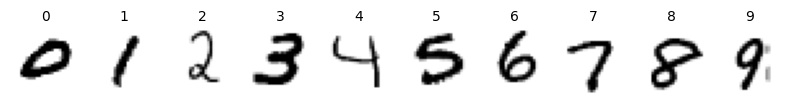

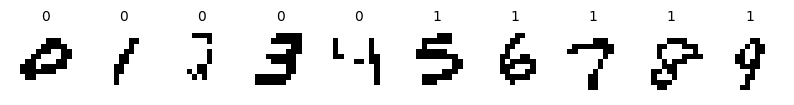

In [6]:
def print_samples(images, labels, elements_per_row=10, fig_width=10, cmap="binary", show_titles=True):
    num_digits = len(images)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    fig_height = fig_width / elements_per_row * num_rows
    fig, axes = plt.subplots(num_rows, elements_per_row, figsize=(fig_width, fig_height))

    axes = axes.flatten() if num_rows > 1 else axes

    for idx in range(len(axes)):
        ax = axes[idx]
        ax.axis('off')
        if idx < num_digits:
            ax.imshow(images[idx].squeeze(), cmap=cmap)
            if show_titles:
                ax.set_title(str(labels[idx]), fontsize=10, pad=2)
            ax.set_aspect('equal')  # force square aspect

    plt.subplots_adjust(wspace=0.1, hspace=0.3 if show_titles else 0.1)
    plt.show()



# use the same demo_indices for raw and binarized images
demo_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
demo_indices = [np.where(train_labels == label)[0][0] for label in demo_labels]

demo_images = train_images[demo_indices]
demo_images_bin = train_images_bin[demo_indices]
demo_labels_bin = train_labels_bin[demo_indices]
print_samples(demo_images, demo_labels, elements_per_row=10, fig_width=10, cmap="gray_r", show_titles=True)
print_samples(demo_images_bin, demo_labels_bin, elements_per_row=10, fig_width=10, cmap="gray_r", show_titles=True)

In [7]:
num_pixels = 196
pixel_labels = [f"p{i}" for i in range(num_pixels)]

test_df = pd.DataFrame(test_images_bin.reshape(-1, num_pixels), columns=pixel_labels)
test_df['label'] = test_labels_bin
test_df = test_df.astype({col: 'bool' for col in pixel_labels + ['label']})

train_df = pd.DataFrame(train_images_bin.reshape(-1, num_pixels), columns=pixel_labels)
train_df['label'] = train_labels_bin
train_df = train_df.astype({col: 'bool' for col in pixel_labels + ['label']})

train_df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p187,p188,p189,p190,p191,p192,p193,p194,p195,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# save both as mnist_train.csv and mnist_test.csv

train_df.to_csv(os.path.join(data_dir, "mnist_train.csv"), index=False)
test_df.to_csv(os.path.join(data_dir, "mnist_test.csv"), index=False)